In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [30]:
# Load Data
filepath = 'ECOMMRecords2020.csv'
data = pd.read_csv(filepath)
data_original = data.copy()

In [ ]:
# Helper function for Coefficient of Variation
import seaborn as sns

def get_coefficient_variation(data, feature):
    grouped_data = data.groupby(feature)
    mean, std = grouped_data["Margin"].mean(), grouped_data["Margin"].std()
    df = pd.concat([mean, std], axis=1).reset_index()
    df.columns = [feature, "Mean", "Std"]
    df["CoefficientOfVariation"] = (df["Std"] / df["Mean"]) ** 2
    return df.sort_values(by="CoefficientOfVariation")

# Split Data by Category
def split_data(feature, data):
    categories = list(data[feature].unique())
    dataframes = {}
    for c in categories:
        df = data[data[feature] == c]
        dataframes[c] = df
    return dataframes

# Feature Engineering Functions
def add_average_margin_feature(dataframe):
    means = dataframe.groupby("ProductName")["Margin"].mean().reset_index()
    means.columns = ["ProductName", "MeanMargin"]
    return pd.merge(means, dataframe, on="ProductName")

def add_total_sales_for_product(dataframe):
    product_sales = dataframe.groupby("ProductID")["Sales"].sum().reset_index()
    product_sales.columns = ["ProductID", "TotalSales"]
    return pd.merge(dataframe, product_sales, on="ProductID", how="left")

def number_of_orders_per_product(dataframe):
    product_order_counts = dataframe.groupby("ProductID")["OrderID"].count().reset_index()
    product_order_counts.columns = ["ProductID", "NumberOfOrders"]
    return dataframe.merge(product_order_counts, on="ProductID", how="left")

# Calculate Total Revenue
def calculate_total_revenue(customer_clustering_data):
    result = {}
    for category in customer_clustering_data.keys():
        data = customer_clustering_data[category]
        cluster_revenues_customer = data.groupby(["CustomerID", "ProductCluster"])["TotalSales"].sum()
        cluster_revenues_customer = cluster_revenues_customer.unstack(fill_value=0)
        cluster_revenues_customer.columns = [f"totalRevenue_PC_{col}" for col in cluster_revenues_customer]
        cluster_revenues_customer = cluster_revenues_customer.reset_index()
        result[category] = pd.merge(data, cluster_revenues_customer, on="CustomerID", how="left")
    return result

# Preprocessing Pipeline for Feature Engineering
def feature_engineering_preprocessing(dataframes, scaler):
    result = {}
    for category in dataframes.keys():
        df = dataframes[category]
        df = number_of_orders_per_product(df)
        df = add_total_sales_for_product(df)
        df = add_average_margin_feature(df)
        result[category] = df
    return result

# Determine Optimal K for Clustering
def find_optimal_k(dataframes, engineered_features):
    ks = list(range(2, 11))
    for category in dataframes.keys():
        data = MinMaxScaler().fit_transform(dataframes[category][engineered_features])
        inertia, silhouette = [], []
        for k in ks:
            model = KMeans(n_clusters=k, random_state=42)
            predicted = model.fit_predict(data)
            inertia.append(model.inertia_)
            silhouette.append(silhouette_score(data, predicted))
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(ks, inertia, marker='o')
        plt.title(f"{category} - Inertia")
        plt.xlabel("Number of Clusters")
        plt.subplot(1, 2, 2)
        plt.plot(ks, silhouette, marker='o')
        plt.title(f"{category} - Silhouette Score")
        plt.xlabel("Number of Clusters")
        plt.tight_layout()
        plt.show()

# Cluster Products
def cluster_product_data(dataframes_scaled, num_clusters, cluster_features, visualize=False):
    scaler = MinMaxScaler()
    for category in dataframes_scaled.keys():
        cluster_data = scaler.fit_transform(dataframes_scaled[category][cluster_features])
        model = KMeans(n_clusters=num_clusters[category], random_state=42)
        dataframes_scaled[category]["ProductCluster"] = model.fit_predict(cluster_data)
        if visualize:
            visualize_clusters(model, cluster_data, f"{category} Product Clusters")

# Cluster Customer Data
def cluster_customer_data(customer_clustering_data, n_clusters, cluster_features, visualize=False):
    scaler = MinMaxScaler()
    for category in customer_clustering_data.keys():
        cluster_data = scaler.fit_transform(customer_clustering_data[category][cluster_features])
        model = KMeans(n_clusters=n_clusters[category], random_state=42)
        customer_clustering_data[category]["CustomerCluster"] = model.fit_predict(cluster_data)
        if visualize:
            visualize_clusters(model, cluster_data, f"{category} Customer Clusters")

# Product Clustering Pipeline
def product_clustering_pipeline(ecommerce_df, visualize=False):
    scaler = MinMaxScaler()
    ecommerce_grouped = split_data(feature="Category", data=ecommerce_df)
    ecommerce_engineered = feature_engineering_preprocessing(ecommerce_grouped, scaler)
    engineered_features = ["TotalSales", "NumberOfOrders", "MeanMargin"]
    num_clusters = {"Technology": 5, "Furniture": 5, "Office Supplies": 5}
    
    cluster_product_data(ecommerce_engineered, num_clusters, engineered_features, visualize=visualize)
    return ecommerce_engineered

# Customer Clustering Pipeline
def customer_clustering_pipeline(customer_clustering_data, visualize=False):
    customer_clustering_data = calculate_total_revenue(customer_clustering_data)
    clustering_features = [f"totalRevenue_PC_{i}" for i in range(5)]

    selected_columns = clustering_features + ["CustomerID"]
    df = customer_clustering_data[selected_columns]
    print(df)
    
    num_clusters = {"Technology": 5, "Furniture": 5, "Office Supplies": 5}
    
    cluster_customer_data(customer_clustering_data, num_clusters, clustering_features, visualize=visualize)
    return customer_clustering_data

# Calculate Recommended Margins
def get_lower_upper_margin(data, customer_cluster):
    margins, cluster_ids = data['margin'], data['cluster_id']
    unique_clusters = np.unique(cluster_ids)
    cluster_percentiles = {}
    for cluster in unique_clusters:
        cluster_margins = margins[cluster_ids == cluster]
        cluster_percentiles[cluster] = {
            '40th_percentile_margin': np.percentile(cluster_margins, 40),
            '75th_percentile_margin': np.percentile(cluster_margins, 75)
        }
    lower_margin = cluster_percentiles[customer_cluster]['40th_percentile_margin']
    upper_margin = cluster_percentiles[customer_cluster]['75th_percentile_margin']
    return lower_margin, upper_margin

# Calculate Price from Margin
def calculate_price(margin, cost):
    return cost / (1 - margin)

# Compute Recommended Price
def compute_recommended_price(complete_data, customer_id, product_id):
    percentile_data = {category: np.array(list(data[['CustomerCluster', 'Margin']].itertuples(index=False, name=None)),dtype=[("cluster_id", int), ("margin", float)])
                       for category, data in complete_data.items()}
    unsplit_data = pd.concat(complete_data.values(), ignore_index=True)
    category = unsplit_data[unsplit_data["ProductID"] == product_id]["Category"].values[0]
    data = complete_data[category]
    cost = data[data["ProductID"] == product_id]["Cost"].values[0]
    customer_cluster = data[data["CustomerID"] == customer_id]["CustomerCluster"].values[0]
    margin_lower, margin_upper = get_lower_upper_margin(percentile_data[category], customer_cluster)
    lower_price = calculate_price(margin_lower, cost)
    upper_price = calculate_price(margin_upper, cost)
    recommended_price = calculate_price((margin_lower + margin_upper) / 2, cost)
    return lower_price, upper_price, recommended_price


# Pipeline to Run the Complete Process
def pipeline(customer_id, product_id, visualize_clusters=True):
    filepath = 'ECOMMRecords2020.csv'
    ecommerce_df = pd.read_csv(filepath)
    
    # Calculate 'Cost' and 'Margin'
    ecommerce_df["Cost"] = (ecommerce_df["Sales"] - ecommerce_df["Profit"]) / ecommerce_df["Quantity"]
    ecommerce_df["Margin"] = ecommerce_df["Profit"] / ecommerce_df["Sales"]
    
    # Product Clustering Pipeline with Visualization
    customer_clustering_data = product_clustering_pipeline(ecommerce_df, visualize=visualize_clusters)
    
    # Customer Clustering Pipeline with Visualization
    complete_data = customer_clustering_pipeline(customer_clustering_data, visualize=visualize_clusters)
    
    # Compute Recommended Price
    lower_price, upper_price, recommended_price = compute_recommended_price(complete_data, customer_id, product_id)
    
    # Print Recommendations
    print(f"For product {product_id} and the customer {customer_id}, we recommend:")
    print(f"Lower sales price: {lower_price:.2f}")
    print(f"Upper sales price: {upper_price:.2f}")
    print(f"Recommended sales price: {recommended_price:.2f}")

def visualize_clusters(model, data, title, random_state=42):
    """
    Visualizes clusters in 2D space using t-SNE.

    Parameters:
    - model: Trained clustering model (e.g., KMeans).
    - data: Scaled feature data used for clustering.
    - title: Title for the plot.
    - random_state: Seed for reproducibility.

    Returns:
    - None (displays a scatter plot).
    """
    # Reduce dimensionality with t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=random_state)
    data_2d = tsne.fit_transform(data)
    
    # Retrieve cluster labels
    labels = model.labels_
    
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'TSNE1': data_2d[:, 0],
        'TSNE2': data_2d[:, 1],
        'Cluster': labels.astype(str)  # Convert to string for categorical plotting
    })
    
    # Set plot style
    sns.set(style="whitegrid", context="notebook")
    
    # Create scatter plot
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        hue='Cluster',
        palette='tab10',
        data=plot_df,
        legend='full',
        alpha=0.7
    )
    
    plt.title(title)
    plt.legend(title='Cluster')
    plt.show()

In [32]:
print()

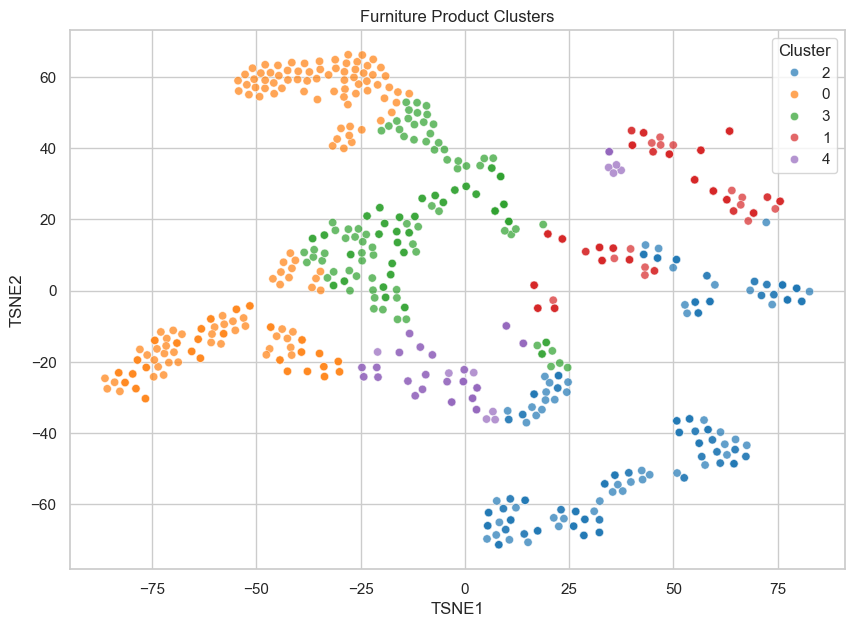

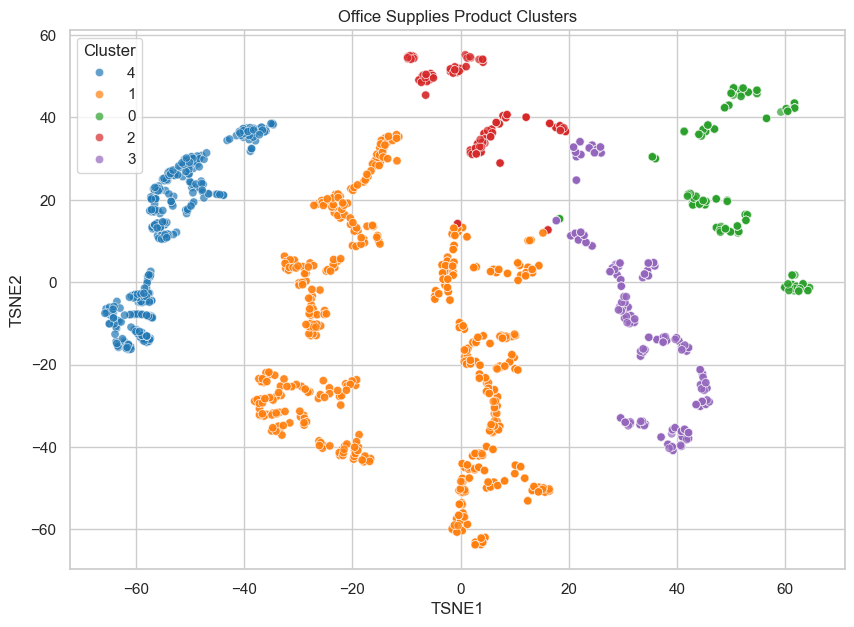

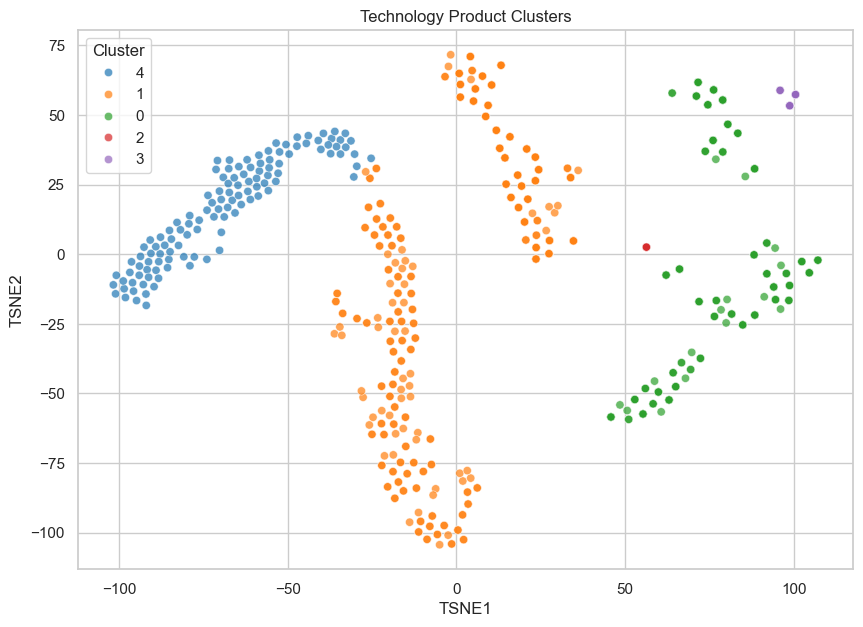

TypeError: unhashable type: 'list'

In [33]:
# Run Example
pipeline("GA-14725", "FUR-FU-10001215", visualize_clusters=True)